🚀 ITC Options Trading System - Advanced Analysis
📊 Fetching ITC stock data...
Current ITC Price: ₹416.55
Historical Volatility: 19.63%
----------------------------------------
📈 Options Pricing Comparison (Call Options)
------------------------------------------------------------
Strike ₹395.72:
  Call: BS=₹24.81, Binomial=₹24.82
  Put:  BS=₹1.88, Binomial=₹1.89
  Greeks: Δ=0.850, Γ=0.0100, Θ=-0.150

Strike ₹416.55:
  Call: BS=₹10.48, Binomial=₹10.46
  Put:  BS=₹8.26, Binomial=₹8.24
  Greeks: Δ=0.549, Γ=0.0169, Θ=-0.194

Strike ₹437.38:
  Call: BS=₹3.03, Binomial=₹3.03
  Put:  BS=₹21.52, Binomial=₹21.53
  Greeks: Δ=0.229, Γ=0.0129, Θ=-0.135

📊 Detailed Comparison Table:
    Strike  BS_Call  Binomial_Call  BS_Put  Binomial_Put  Delta  Gamma  Theta  \
0  395.722   24.812         24.823   1.876         1.887  0.850  0.010 -0.150   
1  416.550   10.479         10.456   8.260         8.237  0.549  0.017 -0.194   
2  437.377    3.025          3.033  21.522        21.530  0.229  0.013 -0.135 

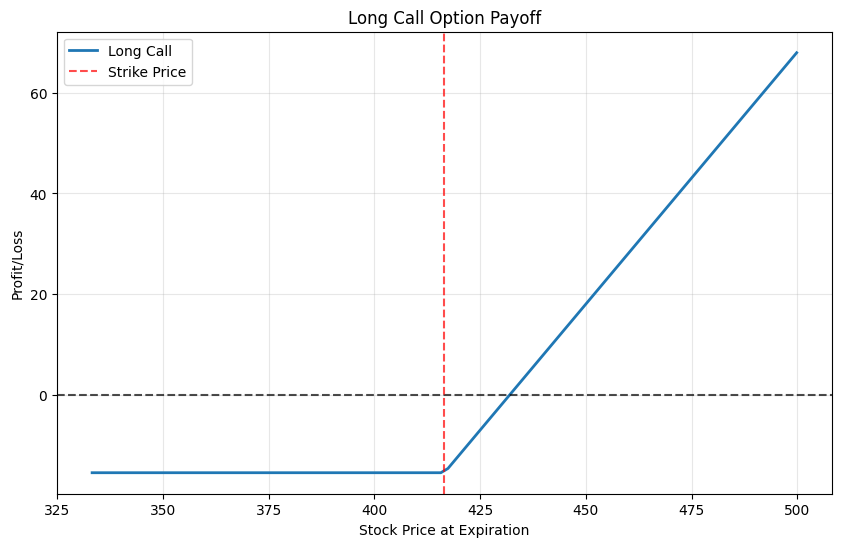

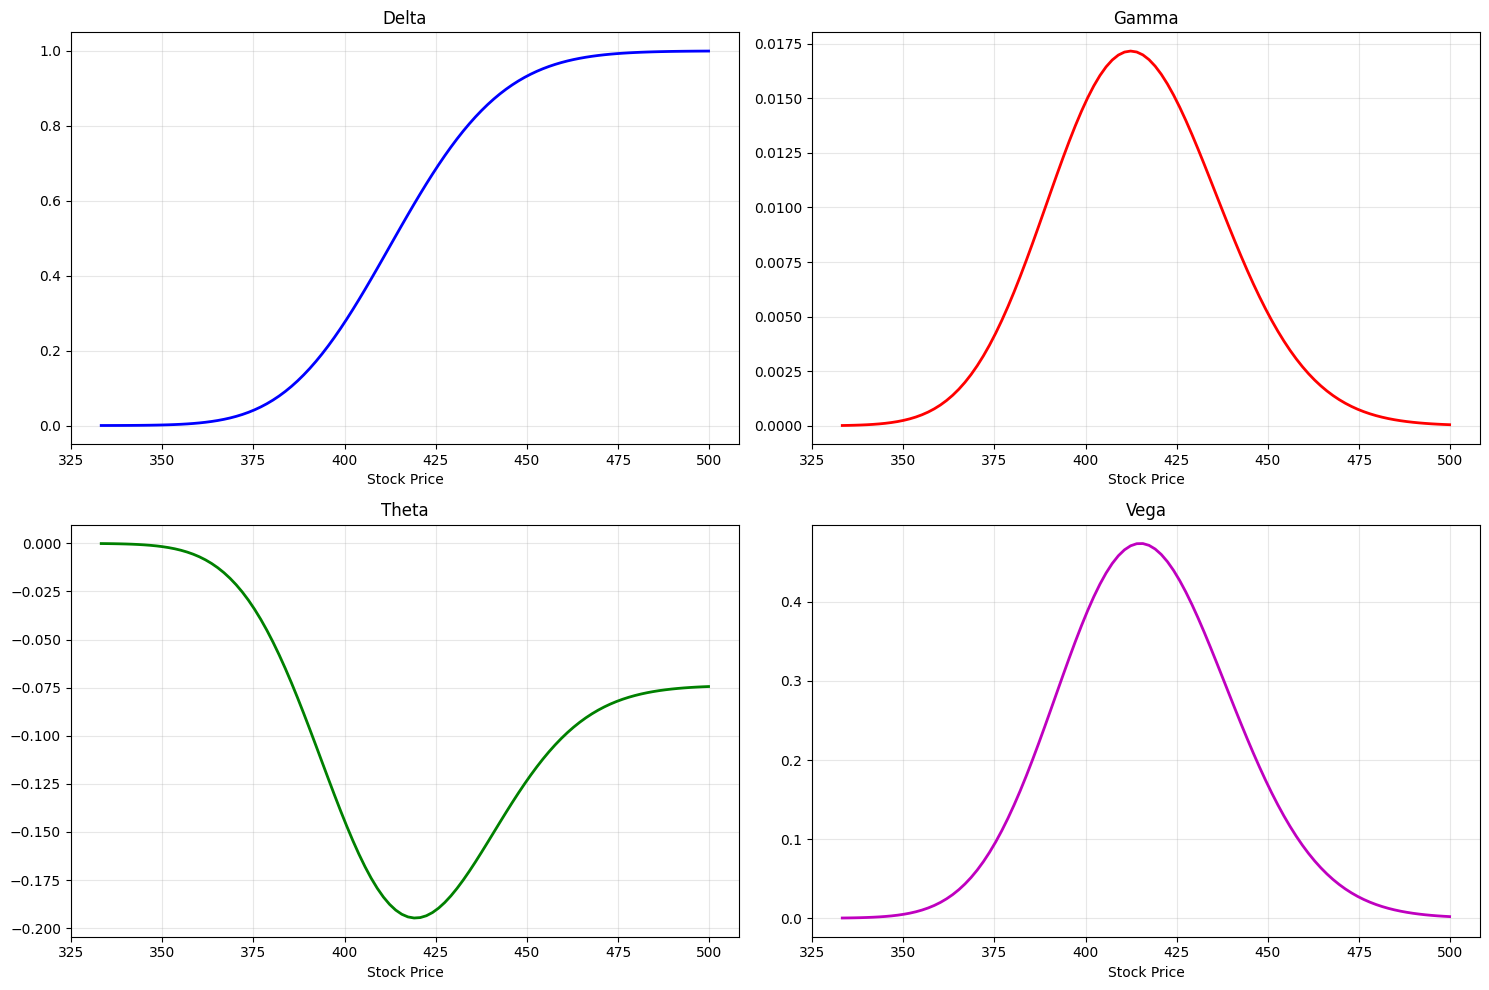

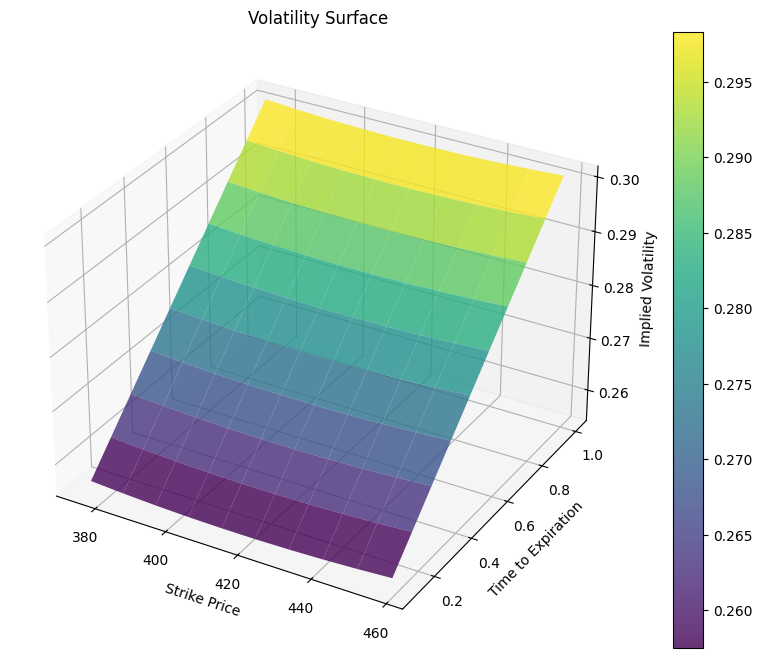

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import datetime, timedelta
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

class OptionsAnalyzer:
    def __init__(self, symbol="ITC.NS"):
        self.symbol = symbol
        self.risk_free_rate = 0.065  # Current Indian risk-free rate (~6.5%)

    def get_stock_data(self, period="1y"):
        """Fetch ITC stock data from Yahoo Finance"""
        try:
            stock = yf.Ticker(self.symbol)
            data = stock.history(period=period)
            return data
        except Exception as e:
            print(f"Error fetching data: {e}")
            return None

    def calculate_volatility(self, data, window=252):
        """Calculate historical volatility"""
        returns = np.log(data['Close'] / data['Close'].shift(1))
        volatility = returns.std() * np.sqrt(window)
        return volatility

    def black_scholes(self, S, K, T, r, sigma, option_type='call'):
        """
        Black-Scholes Option Pricing Model
        S: Current stock price
        K: Strike price
        T: Time to expiration (in years)
        r: Risk-free rate
        sigma: Volatility
        option_type: 'call' or 'put'
        """
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type == 'call':
            price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

        return price

    def greeks(self, S, K, T, r, sigma, option_type='call'):
        """Calculate option Greeks"""
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        # Delta
        if option_type == 'call':
            delta = norm.cdf(d1)
        else:
            delta = norm.cdf(d1) - 1

        # Gamma
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))

        # Theta
        if option_type == 'call':
            theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                    - r * K * np.exp(-r * T) * norm.cdf(d2)) / 365
        else:
            theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                    + r * K * np.exp(-r * T) * norm.cdf(-d2)) / 365

        # Vega
        vega = S * norm.pdf(d1) * np.sqrt(T) / 100

        # Rho
        if option_type == 'call':
            rho = K * T * np.exp(-r * T) * norm.cdf(d2) / 100
        else:
            rho = -K * T * np.exp(-r * T) * norm.cdf(-d2) / 100

        return {
            'delta': delta,
            'gamma': gamma,
            'theta': theta,
            'vega': vega,
            'rho': rho
        }

    def binomial_tree(self, S, K, T, r, sigma, n, option_type='call', american=False):
        """
        Advanced Binomial Tree Model for Option Pricing
        n: Number of time steps
        american: True for American options, False for European
        """
        dt = T / n
        u = np.exp(sigma * np.sqrt(dt))  # Up factor
        d = 1 / u  # Down factor
        p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

        # Initialize asset prices at maturity
        S_tree = np.zeros((n + 1, n + 1))
        for i in range(n + 1):
            for j in range(i + 1):
                S_tree[j, i] = S * (u ** (i - j)) * (d ** j)

        # Initialize option values at maturity
        option_tree = np.zeros((n + 1, n + 1))
        for j in range(n + 1):
            if option_type == 'call':
                option_tree[j, n] = max(0, S_tree[j, n] - K)
            else:
                option_tree[j, n] = max(0, K - S_tree[j, n])

        # Backward induction
        for i in range(n - 1, -1, -1):
            for j in range(i + 1):
                # European option value
                european_value = (p * option_tree[j, i + 1] +
                                (1 - p) * option_tree[j + 1, i + 1]) * np.exp(-r * dt)

                if american:
                    # American option - compare with intrinsic value
                    if option_type == 'call':
                        intrinsic_value = max(0, S_tree[j, i] - K)
                    else:
                        intrinsic_value = max(0, K - S_tree[j, i])

                    option_tree[j, i] = max(european_value, intrinsic_value)
                else:
                    option_tree[j, i] = european_value

        return option_tree[0, 0], S_tree, option_tree

    def implied_volatility(self, market_price, S, K, T, r, option_type='call', max_iter=100, tolerance=1e-6):
        """Calculate implied volatility using Newton-Raphson method"""
        sigma = 0.3  # Initial guess

        for i in range(max_iter):
            price = self.black_scholes(S, K, T, r, sigma, option_type)
            vega = self.greeks(S, K, T, r, sigma, option_type)['vega'] * 100

            diff = price - market_price
            if abs(diff) < tolerance:
                return sigma

            if vega == 0:
                break

            sigma = sigma - diff / vega

            if sigma <= 0:
                sigma = 0.01

        return sigma

class TradingStrategy:
    def __init__(self, options_analyzer):
        self.analyzer = options_analyzer
        self.portfolio = {'cash': 100000, 'positions': []}  # Starting with 1 lakh

    def delta_hedging_strategy(self, S, strike_prices, expiry_days, option_type='call'):
        """Delta hedging strategy"""
        T = expiry_days / 365
        sigma = 0.3  # Assumed volatility

        results = []
        for K in strike_prices:
            bs_price = self.analyzer.black_scholes(S, K, T, self.analyzer.risk_free_rate, sigma, option_type)
            bin_price, _, _ = self.analyzer.binomial_tree(S, K, T, self.analyzer.risk_free_rate, sigma, 100, option_type)
            greeks = self.analyzer.greeks(S, K, T, self.analyzer.risk_free_rate, sigma, option_type)

            results.append({
                'strike': K,
                'bs_price': bs_price,
                'binomial_price': bin_price,
                'delta': greeks['delta'],
                'gamma': greeks['gamma'],
                'theta': greeks['theta'],
                'vega': greeks['vega'],
                'moneyness': S / K
            })

        return pd.DataFrame(results)

    def volatility_trading_strategy(self, S, K, T, market_price, option_type='call'):
        """Volatility-based trading strategy"""
        # Calculate implied volatility
        iv = self.analyzer.implied_volatility(market_price, S, K, T, self.analyzer.risk_free_rate, option_type)

        # Calculate historical volatility (assumed 25% for demo)
        hv = 0.25

        # Trading signal based on IV vs HV
        if iv > hv * 1.2:  # IV is 20% higher than HV
            signal = 'SELL'  # Sell overpriced options
            confidence = min((iv - hv) / hv, 1.0)
        elif iv < hv * 0.8:  # IV is 20% lower than HV
            signal = 'BUY'   # Buy underpriced options
            confidence = min((hv - iv) / hv, 1.0)
        else:
            signal = 'HOLD'
            confidence = 0

        return {
            'signal': signal,
            'confidence': confidence,
            'implied_vol': iv,
            'historical_vol': hv,
            'vol_premium': (iv - hv) / hv
        }

    def momentum_strategy(self, price_data, lookback=20):
        """Momentum-based options strategy"""
        returns = price_data['Close'].pct_change()
        momentum = returns.rolling(window=lookback).mean()
        volatility = returns.rolling(window=lookback).std()

        current_momentum = momentum.iloc[-1]
        current_vol = volatility.iloc[-1]

        if current_momentum > 0.02 and current_vol > 0.025:
            return {'signal': 'BUY_CALL', 'strength': 'HIGH'}
        elif current_momentum < -0.02 and current_vol > 0.025:
            return {'signal': 'BUY_PUT', 'strength': 'HIGH'}
        elif abs(current_momentum) < 0.01 and current_vol < 0.015:
            return {'signal': 'SELL_STRADDLE', 'strength': 'MEDIUM'}
        else:
            return {'signal': 'HOLD', 'strength': 'LOW'}

class OptionsVisualizer:
    def __init__(self, analyzer):
        self.analyzer = analyzer

    def plot_payoff_diagram(self, S_range, K, premium, option_type='call', position='long'):
        """Plot option payoff diagram"""
        payoffs = []

        for S in S_range:
            if option_type == 'call':
                intrinsic = max(0, S - K)
            else:
                intrinsic = max(0, K - S)

            if position == 'long':
                payoff = intrinsic - premium
            else:
                payoff = premium - intrinsic

            payoffs.append(payoff)

        plt.figure(figsize=(10, 6))
        plt.plot(S_range, payoffs, linewidth=2, label=f'{position.title()} {option_type.title()}')
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        plt.axvline(x=K, color='red', linestyle='--', alpha=0.7, label='Strike Price')
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Profit/Loss')
        plt.title(f'{position.title()} {option_type.title()} Option Payoff')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_volatility_surface(self, S, strikes, expiries, r, base_vol=0.25):
        """Plot implied volatility surface"""
        vol_matrix = []

        for T in expiries:
            vol_row = []
            for K in strikes:
                # Simulate volatility smile
                moneyness = K / S
                vol = base_vol + 0.1 * (moneyness - 1)**2 + 0.05 * T
                vol_row.append(vol)
            vol_matrix.append(vol_row)

        vol_matrix = np.array(vol_matrix)

        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        X, Y = np.meshgrid(strikes, expiries)
        surf = ax.plot_surface(X, Y, vol_matrix, cmap='viridis', alpha=0.8)

        ax.set_xlabel('Strike Price')
        ax.set_ylabel('Time to Expiration')
        ax.set_zlabel('Implied Volatility')
        ax.set_title('Volatility Surface')

        fig.colorbar(surf)
        plt.show()

    def plot_greeks(self, S_range, K, T, r, sigma, option_type='call'):
        """Plot option Greeks"""
        deltas, gammas, thetas, vegas = [], [], [], []

        for S in S_range:
            greeks = self.analyzer.greeks(S, K, T, r, sigma, option_type)
            deltas.append(greeks['delta'])
            gammas.append(greeks['gamma'])
            thetas.append(greeks['theta'])
            vegas.append(greeks['vega'])

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        axes[0, 0].plot(S_range, deltas, 'b-', linewidth=2)
        axes[0, 0].set_title('Delta')
        axes[0, 0].set_xlabel('Stock Price')
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(S_range, gammas, 'r-', linewidth=2)
        axes[0, 1].set_title('Gamma')
        axes[0, 1].set_xlabel('Stock Price')
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].plot(S_range, thetas, 'g-', linewidth=2)
        axes[1, 0].set_title('Theta')
        axes[1, 0].set_xlabel('Stock Price')
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].plot(S_range, vegas, 'm-', linewidth=2)
        axes[1, 1].set_title('Vega')
        axes[1, 1].set_xlabel('Stock Price')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Main execution and testing
def main():
    print("🚀 ITC Options Trading System - Advanced Analysis")
    print("=" * 60)

    # Initialize the system
    analyzer = OptionsAnalyzer("ITC.NS")
    strategy = TradingStrategy(analyzer)
    visualizer = OptionsVisualizer(analyzer)

    # Fetch ITC data
    print("📊 Fetching ITC stock data...")
    stock_data = analyzer.get_stock_data()

    if stock_data is not None:
        current_price = stock_data['Close'].iloc[-1]
        volatility = analyzer.calculate_volatility(stock_data)

        print(f"Current ITC Price: ₹{current_price:.2f}")
        print(f"Historical Volatility: {volatility:.2%}")
        print("-" * 40)

        # Options parameters
        strike_prices = [current_price * i for i in [0.95, 1.0, 1.05]]  # ATM, ITM, OTM
        expiry_days = 30
        T = expiry_days / 365

        # Black-Scholes vs Binomial Tree Comparison
        print("📈 Options Pricing Comparison (Call Options)")
        print("-" * 60)

        comparison_data = []
        for K in strike_prices:
            bs_call = analyzer.black_scholes(current_price, K, T, analyzer.risk_free_rate, volatility, 'call')
            bs_put = analyzer.black_scholes(current_price, K, T, analyzer.risk_free_rate, volatility, 'put')

            bin_call, _, _ = analyzer.binomial_tree(current_price, K, T, analyzer.risk_free_rate, volatility, 100, 'call')
            bin_put, _, _ = analyzer.binomial_tree(current_price, K, T, analyzer.risk_free_rate, volatility, 100, 'put')

            greeks = analyzer.greeks(current_price, K, T, analyzer.risk_free_rate, volatility, 'call')

            comparison_data.append({
                'Strike': K,
                'BS_Call': bs_call,
                'Binomial_Call': bin_call,
                'BS_Put': bs_put,
                'Binomial_Put': bin_put,
                'Delta': greeks['delta'],
                'Gamma': greeks['gamma'],
                'Theta': greeks['theta'],
                'Vega': greeks['vega']
            })

            print(f"Strike ₹{K:.2f}:")
            print(f"  Call: BS=₹{bs_call:.2f}, Binomial=₹{bin_call:.2f}")
            print(f"  Put:  BS=₹{bs_put:.2f}, Binomial=₹{bin_put:.2f}")
            print(f"  Greeks: Δ={greeks['delta']:.3f}, Γ={greeks['gamma']:.4f}, Θ={greeks['theta']:.3f}")
            print()

        # Create comparison DataFrame
        df_comparison = pd.DataFrame(comparison_data)
        print("📊 Detailed Comparison Table:")
        print(df_comparison.round(3))
        print()

        # Trading Strategy Analysis
        print("🎯 Trading Strategy Recommendations")
        print("-" * 40)

        # Delta hedging strategy
        delta_analysis = strategy.delta_hedging_strategy(current_price, strike_prices, expiry_days)
        print("Delta Hedging Analysis:")
        print(delta_analysis[['strike', 'bs_price', 'delta', 'moneyness']].round(3))
        print()

        # Volatility strategy (assuming market price)
        market_price = delta_analysis.iloc[1]['bs_price']  # Use ATM option price
        vol_strategy = strategy.volatility_trading_strategy(
            current_price, strike_prices[1], T, market_price
        )
        print("Volatility Strategy:")
        print(f"Signal: {vol_strategy['signal']}")
        print(f"Confidence: {vol_strategy['confidence']:.2%}")
        print(f"IV: {vol_strategy['implied_vol']:.2%}")
        print(f"HV: {vol_strategy['historical_vol']:.2%}")
        print()

        # Momentum strategy
        momentum = strategy.momentum_strategy(stock_data)
        print("Momentum Strategy:")
        print(f"Signal: {momentum['signal']}")
        print(f"Strength: {momentum['strength']}")
        print()

        # Visualizations
        print("📊 Generating Visualizations...")

        # Payoff diagram
        S_range = np.linspace(current_price * 0.8, current_price * 1.2, 100)
        visualizer.plot_payoff_diagram(S_range, strike_prices[1], delta_analysis.iloc[1]['bs_price'], 'call', 'long')

        # Greeks visualization
        visualizer.plot_greeks(S_range, strike_prices[1], T, analyzer.risk_free_rate, volatility, 'call')

        # Volatility surface
        strikes_surface = np.linspace(current_price * 0.9, current_price * 1.1, 10)
        expiries_surface = np.linspace(0.1, 1.0, 10)
        visualizer.plot_volatility_surface(current_price, strikes_surface, expiries_surface, analyzer.risk_free_rate)

    else:
        print("❌ Could not fetch ITC data. Using sample data for demonstration.")

        # Sample data for testing
        sample_price = 450
        sample_vol = 0.25

        print(f"Sample ITC Price: ₹{sample_price}")
        print(f"Sample Volatility: {sample_vol:.2%}")

        # Continue with sample analysis...
        K = sample_price
        T = 30/365

        bs_price = analyzer.black_scholes(sample_price, K, T, analyzer.risk_free_rate, sample_vol, 'call')
        bin_price, _, _ = analyzer.binomial_tree(sample_price, K, T, analyzer.risk_free_rate, sample_vol, 100, 'call')

        print(f"ATM Call Option:")
        print(f"  Black-Scholes: ₹{bs_price:.2f}")
        print(f"  Binomial Tree: ₹{bin_price:.2f}")

if __name__ == "__main__":
    main()

ITC STOCK BINOMIAL TREE OPTION PRICING
Spot Price: ₹450.0
Strike Price: ₹460.0
Time to Expiry: 0.25 years
Risk-free Rate: 6.0%
Volatility: 25.0%
Steps: 100

OPTION PRICES:
----------------------------------------
European Call: ₹20.95
European Put:  ₹24.10
American Call: ₹20.95
American Put:  ₹24.92

GREEKS (European Options):
----------------------------------------
CALL OPTION:
  Delta: 0.5053
  Gamma: 0.012352
  Theta: ₹-0.1586/day

PUT OPTION:
  Delta: -0.4947
  Gamma: 0.012352
  Theta: ₹-0.0841/day

PUT-CALL PARITY VERIFICATION:
----------------------------------------
C - P = ₹-3.1515
S - K*e^(-rT) = ₹-3.1515
Difference: ₹0.000000

TRADING INSIGHTS:
----------------------------------------
• Call option has high delta - consider for bullish strategies
• Put option has low absolute delta - limited downside protection
• Moderate time decay - suitable for longer-term holds

SENSITIVITY ANALYSIS:
----------------------------------------
Volatility Impact on Call Price:
  Vol: 15.0% →

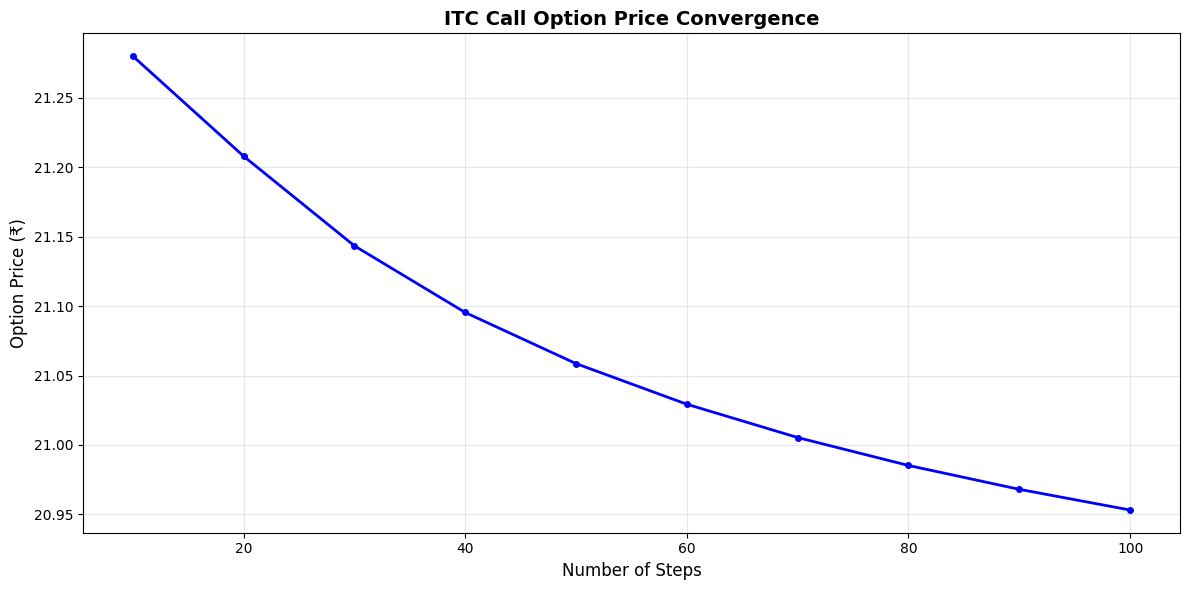

Price convergence with increasing steps:
  Steps:  60 → Price: ₹21.0293
  Steps:  70 → Price: ₹21.0054
  Steps:  80 → Price: ₹20.9852
  Steps:  90 → Price: ₹20.9681
  Steps: 100 → Price: ₹20.9532


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
from enum import Enum

class OptionType(Enum):
    CALL = "call"
    PUT = "put"

class ITCBinomialTree:
    """
    Binomial Tree Implementation for ITC Stock Option Pricing

    This class implements the Cox-Ross-Rubinstein binomial tree model
    specifically calibrated for ITC stock characteristics.
    """

    def __init__(self, spot_price: float, strike_price: float,
                 time_to_expiry: float, risk_free_rate: float,
                 volatility: float, steps: int = 100):
        """
        Initialize the binomial tree for ITC stock

        Parameters:
        - spot_price: Current ITC stock price (₹)
        - strike_price: Option strike price (₹)
        - time_to_expiry: Time to expiration in years
        - risk_free_rate: Risk-free interest rate (as decimal)
        - volatility: Implied volatility (as decimal)
        - steps: Number of time steps in the tree
        """
        self.S0 = spot_price
        self.K = strike_price
        self.T = time_to_expiry
        self.r = risk_free_rate
        self.sigma = volatility
        self.N = steps

        # Calculate binomial parameters
        self.dt = self.T / self.N
        self.u = np.exp(self.sigma * np.sqrt(self.dt))  # Up factor
        self.d = 1 / self.u  # Down factor
        self.p = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)  # Risk-neutral probability
        self.discount_factor = np.exp(-self.r * self.dt)

        # Validation
        if not (0 < self.p < 1):
            raise ValueError("Risk-neutral probability must be between 0 and 1")

    def build_stock_price_tree(self) -> np.ndarray:
        """Build the stock price tree for ITC"""
        tree = np.zeros((self.N + 1, self.N + 1))

        # Fill the tree with stock prices
        for i in range(self.N + 1):
            for j in range(i + 1):
                tree[j, i] = self.S0 * (self.u ** (i - j)) * (self.d ** j)

        return tree

    def calculate_option_payoff(self, stock_price: float, option_type: OptionType) -> float:
        """Calculate option payoff at expiration"""
        if option_type == OptionType.CALL:
            return max(stock_price - self.K, 0)
        else:  # PUT
            return max(self.K - stock_price, 0)

    def price_european_option(self, option_type: OptionType) -> Tuple[float, np.ndarray]:
        """
        Price European option using binomial tree

        Returns:
        - option_price: Fair value of the option
        - option_tree: Tree showing option values at each node
        """
        stock_tree = self.build_stock_price_tree()
        option_tree = np.zeros((self.N + 1, self.N + 1))

        # Calculate option values at expiration (terminal nodes)
        for j in range(self.N + 1):
            option_tree[j, self.N] = self.calculate_option_payoff(
                stock_tree[j, self.N], option_type
            )

        # Backward induction to calculate option values
        for i in range(self.N - 1, -1, -1):
            for j in range(i + 1):
                option_tree[j, i] = self.discount_factor * (
                    self.p * option_tree[j, i + 1] +
                    (1 - self.p) * option_tree[j + 1, i + 1]
                )

        return option_tree[0, 0], option_tree

    def price_american_option(self, option_type: OptionType) -> Tuple[float, np.ndarray]:
        """
        Price American option using binomial tree

        Returns:
        - option_price: Fair value of the option
        - option_tree: Tree showing option values at each node
        """
        stock_tree = self.build_stock_price_tree()
        option_tree = np.zeros((self.N + 1, self.N + 1))

        # Calculate option values at expiration
        for j in range(self.N + 1):
            option_tree[j, self.N] = self.calculate_option_payoff(
                stock_tree[j, self.N], option_type
            )

        # Backward induction with early exercise check
        for i in range(self.N - 1, -1, -1):
            for j in range(i + 1):
                # European value (continuation value)
                continuation_value = self.discount_factor * (
                    self.p * option_tree[j, i + 1] +
                    (1 - self.p) * option_tree[j + 1, i + 1]
                )

                # Exercise value
                exercise_value = self.calculate_option_payoff(
                    stock_tree[j, i], option_type
                )

                # American option value is max of continuation and exercise
                option_tree[j, i] = max(continuation_value, exercise_value)

        return option_tree[0, 0], option_tree

    def calculate_greeks(self, option_type: OptionType) -> dict:
        """Calculate option Greeks using binomial tree"""
        # Get base option price
        base_price, _ = self.price_european_option(option_type)

        # Delta calculation (price sensitivity to underlying)
        delta_shift = 0.01 * self.S0  # 1% shift
        self.S0 += delta_shift
        up_price, _ = self.price_european_option(option_type)
        self.S0 -= 2 * delta_shift
        down_price, _ = self.price_european_option(option_type)
        self.S0 += delta_shift  # Reset to original

        delta = (up_price - down_price) / (2 * delta_shift)

        # Gamma calculation (delta sensitivity)
        gamma = (up_price - 2 * base_price + down_price) / (delta_shift ** 2)

        # Theta calculation (time decay)
        original_T = self.T
        self.T -= 1/365  # One day less
        self.dt = self.T / self.N
        self.u = np.exp(self.sigma * np.sqrt(self.dt))
        self.d = 1 / self.u
        self.p = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)
        self.discount_factor = np.exp(-self.r * self.dt)

        theta_price, _ = self.price_european_option(option_type)
        theta = theta_price - base_price  # Negative value indicating decay

        # Reset original values
        self.T = original_T
        self.dt = self.T / self.N
        self.u = np.exp(self.sigma * np.sqrt(self.dt))
        self.d = 1 / self.u
        self.p = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)
        self.discount_factor = np.exp(-self.r * self.dt)

        return {
            'delta': delta,
            'gamma': gamma,
            'theta': theta
        }

    def sensitivity_analysis(self, option_type: OptionType) -> pd.DataFrame:
        """Perform sensitivity analysis for different parameters"""
        base_price, _ = self.price_european_option(option_type)

        results = []

        # Volatility sensitivity
        vol_range = np.arange(0.15, 0.45, 0.05)
        original_vol = self.sigma
        for vol in vol_range:
            self.sigma = vol
            self.u = np.exp(self.sigma * np.sqrt(self.dt))
            self.d = 1 / self.u
            self.p = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)
            price, _ = self.price_european_option(option_type)
            results.append({
                'Parameter': 'Volatility',
                'Value': vol,
                'Option Price': price,
                'Price Change': price - base_price
            })

        # Reset volatility
        self.sigma = original_vol
        self.u = np.exp(self.sigma * np.sqrt(self.dt))
        self.d = 1 / self.u
        self.p = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)

        # Spot price sensitivity
        spot_range = np.arange(0.8 * self.S0, 1.2 * self.S0, 0.05 * self.S0)
        original_spot = self.S0
        for spot in spot_range:
            self.S0 = spot
            price, _ = self.price_european_option(option_type)
            results.append({
                'Parameter': 'Spot Price',
                'Value': spot,
                'Option Price': price,
                'Price Change': price - base_price
            })

        # Reset spot price
        self.S0 = original_spot

        return pd.DataFrame(results)

    def plot_convergence(self, option_type: OptionType, max_steps: int = 200):
        """Plot option price convergence as number of steps increases"""
        steps_range = range(10, max_steps + 1, 10)
        prices = []

        original_N = self.N

        for n in steps_range:
            self.N = n
            self.dt = self.T / self.N
            self.u = np.exp(self.sigma * np.sqrt(self.dt))
            self.d = 1 / self.u
            self.p = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)
            self.discount_factor = np.exp(-self.r * self.dt)

            price, _ = self.price_european_option(option_type)
            prices.append(price)

        # Reset original steps
        self.N = original_N
        self.dt = self.T / self.N
        self.u = np.exp(self.sigma * np.sqrt(self.dt))
        self.d = 1 / self.u
        self.p = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)
        self.discount_factor = np.exp(-self.r * self.dt)

        plt.figure(figsize=(12, 6))
        plt.plot(steps_range, prices, 'b-', linewidth=2, marker='o', markersize=4)
        plt.title(f'ITC {option_type.value.title()} Option Price Convergence', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Steps', fontsize=12)
        plt.ylabel('Option Price (₹)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return list(zip(steps_range, prices))

def demo_itc_binomial_tree():
    """Demonstration of ITC binomial tree option pricing"""

    # ITC stock parameters (example values)
    spot_price = 450.0  # Current ITC stock price in ₹
    strike_price = 460.0  # Strike price in ₹
    time_to_expiry = 0.25  # 3 months
    risk_free_rate = 0.06  # 6% annual risk-free rate
    volatility = 0.25  # 25% annual volatility
    steps = 100

    print("=" * 60)
    print("ITC STOCK BINOMIAL TREE OPTION PRICING")
    print("=" * 60)
    print(f"Spot Price: ₹{spot_price}")
    print(f"Strike Price: ₹{strike_price}")
    print(f"Time to Expiry: {time_to_expiry} years")
    print(f"Risk-free Rate: {risk_free_rate:.1%}")
    print(f"Volatility: {volatility:.1%}")
    print(f"Steps: {steps}")
    print("=" * 60)

    # Create binomial tree
    itc_tree = ITCBinomialTree(
        spot_price=spot_price,
        strike_price=strike_price,
        time_to_expiry=time_to_expiry,
        risk_free_rate=risk_free_rate,
        volatility=volatility,
        steps=steps
    )

    # Price European options
    call_price_eur, _ = itc_tree.price_european_option(OptionType.CALL)
    put_price_eur, _ = itc_tree.price_european_option(OptionType.PUT)

    # Price American options
    call_price_amer, _ = itc_tree.price_american_option(OptionType.CALL)
    put_price_amer, _ = itc_tree.price_american_option(OptionType.PUT)

    print("\nOPTION PRICES:")
    print("-" * 40)
    print(f"European Call: ₹{call_price_eur:.2f}")
    print(f"European Put:  ₹{put_price_eur:.2f}")
    print(f"American Call: ₹{call_price_amer:.2f}")
    print(f"American Put:  ₹{put_price_amer:.2f}")

    # Calculate Greeks for European call
    call_greeks = itc_tree.calculate_greeks(OptionType.CALL)
    put_greeks = itc_tree.calculate_greeks(OptionType.PUT)

    print("\nGREEKS (European Options):")
    print("-" * 40)
    print("CALL OPTION:")
    print(f"  Delta: {call_greeks['delta']:.4f}")
    print(f"  Gamma: {call_greeks['gamma']:.6f}")
    print(f"  Theta: ₹{call_greeks['theta']:.4f}/day")

    print("\nPUT OPTION:")
    print(f"  Delta: {put_greeks['delta']:.4f}")
    print(f"  Gamma: {put_greeks['gamma']:.6f}")
    print(f"  Theta: ₹{put_greeks['theta']:.4f}/day")

    # Verify Put-Call Parity
    pcp_lhs = call_price_eur - put_price_eur
    pcp_rhs = spot_price - strike_price * np.exp(-risk_free_rate * time_to_expiry)

    print(f"\nPUT-CALL PARITY VERIFICATION:")
    print("-" * 40)
    print(f"C - P = ₹{pcp_lhs:.4f}")
    print(f"S - K*e^(-rT) = ₹{pcp_rhs:.4f}")
    print(f"Difference: ₹{abs(pcp_lhs - pcp_rhs):.6f}")

    # Trading strategy suggestion
    print(f"\nTRADING INSIGHTS:")
    print("-" * 40)
    if call_greeks['delta'] > 0.5:
        print("• Call option has high delta - consider for bullish strategies")
    else:
        print("• Call option has low delta - limited upside exposure")

    if abs(put_greeks['delta']) > 0.5:
        print("• Put option has high absolute delta - good for hedging")
    else:
        print("• Put option has low absolute delta - limited downside protection")

    if call_greeks['theta'] < -0.5:
        print("• High time decay - consider shorter-term strategies")
    else:
        print("• Moderate time decay - suitable for longer-term holds")

    return itc_tree

# Run the demonstration
if __name__ == "__main__":
    tree = demo_itc_binomial_tree()

    # Generate sensitivity analysis
    print(f"\nSENSITIVITY ANALYSIS:")
    print("-" * 40)
    sensitivity_df = tree.sensitivity_analysis(OptionType.CALL)

    # Show volatility sensitivity
    vol_data = sensitivity_df[sensitivity_df['Parameter'] == 'Volatility']
    print("Volatility Impact on Call Price:")
    for _, row in vol_data.iterrows():
        print(f"  Vol: {row['Value']:.1%} → Price: ₹{row['Option Price']:.2f} (Δ₹{row['Price Change']:+.2f})")

    # Show convergence analysis
    print(f"\nCONVERGENCE ANALYSIS:")
    print("-" * 40)
    convergence_data = tree.plot_convergence(OptionType.CALL, max_steps=100)
    print("Price convergence with increasing steps:")
    for steps, price in convergence_data[-5:]:  # Show last 5 values
        print(f"  Steps: {steps:3d} → Price: ₹{price:.4f}")